# Exploratory Data Analysis on Order Features

Goal:
- ❓ Inspect each order features to gain an initial understanding of its characertistics
- ❓ Which feature seems to be impacting the review score the most? 


In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
#Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Import order training set
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

## 1 - Feature Inspection

📈 Plot histograms to get a sense of the distribution of each numerical feature.

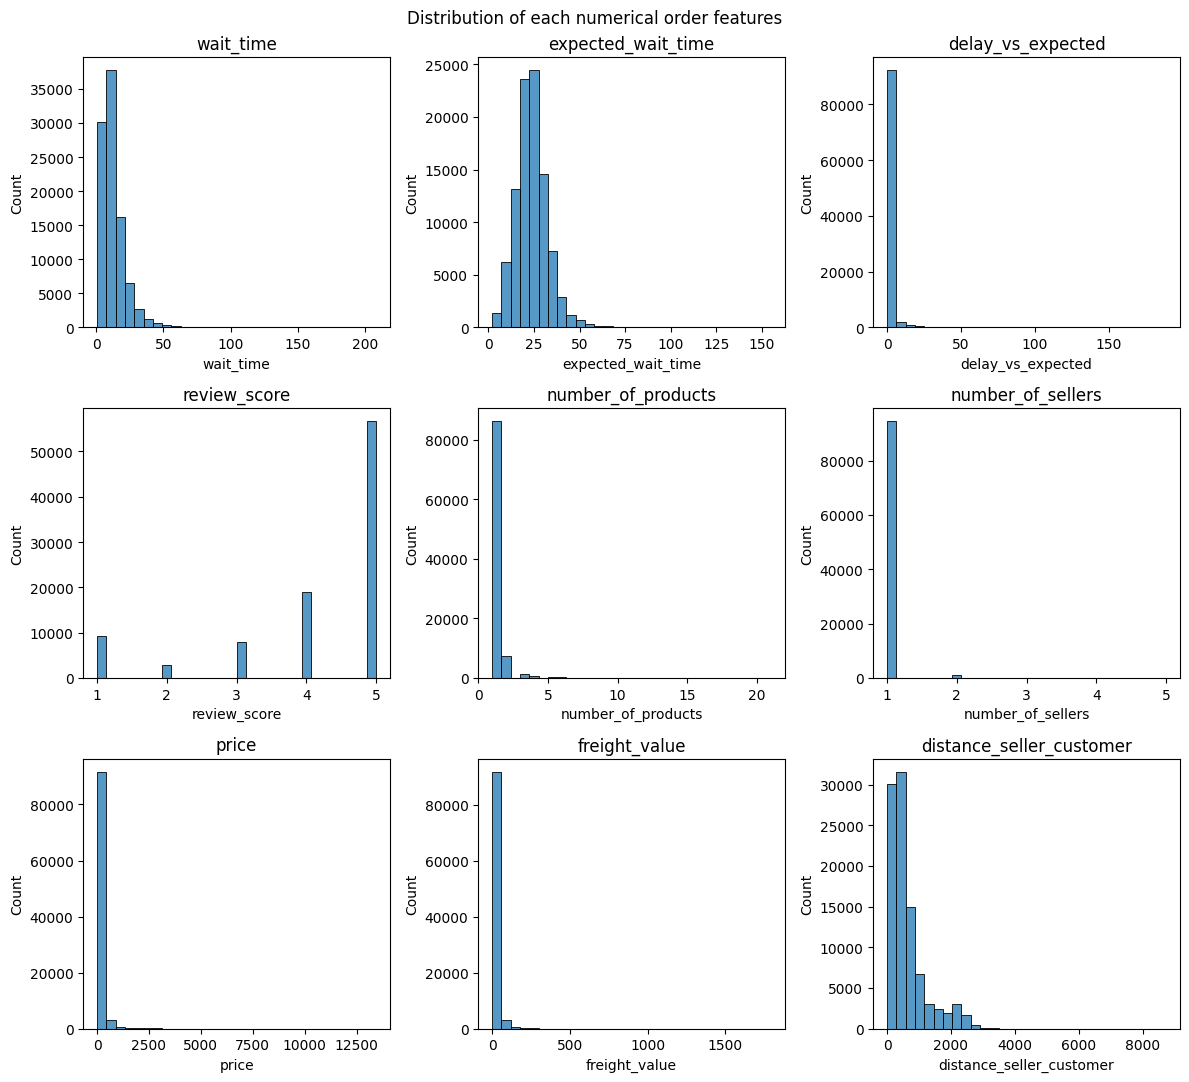

In [86]:
hist_columns = ['wait_time', 'expected_wait_time', 'delay_vs_expected','review_score','number_of_products',
 'number_of_sellers', 'price', 'freight_value','distance_seller_customer']

fig,axs = plt.subplots(3,3,figsize=(12,11))
axs = axs.flatten()
for i,column in enumerate(hist_columns):
    sns.histplot(data=orders,x=column,bins=30,ax=axs[i])
    axs[i].set_title(column)
plt.suptitle("Distribution of each numerical order features")
plt.tight_layout()
plt.show();

📈 Plot historgrams for each `review score` vs. `wait time`

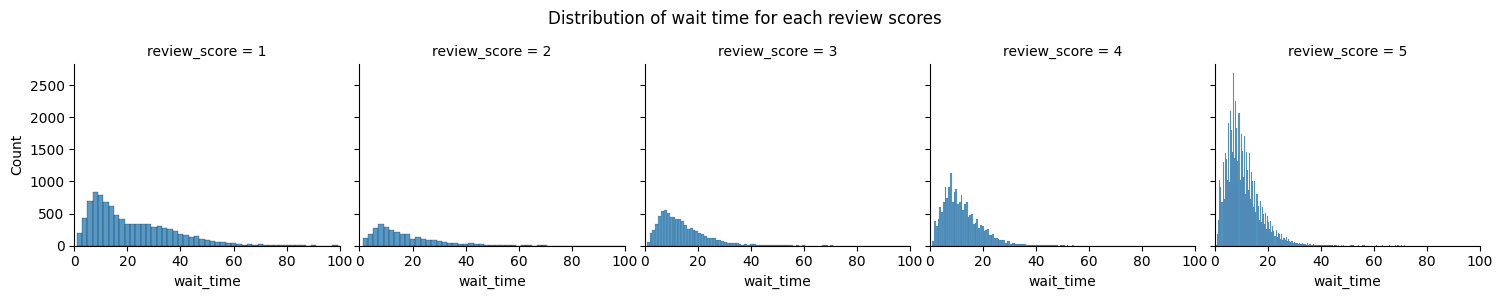

In [19]:
g = sns.FacetGrid(data=orders,col='review_score')
g.map(sns.histplot,'wait_time')
g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("Distribution of wait time for each review scores")
g.set(xlim=(0,100))

❓Inspect the various correlations between features: which feature seems to the most correlated with review_score?

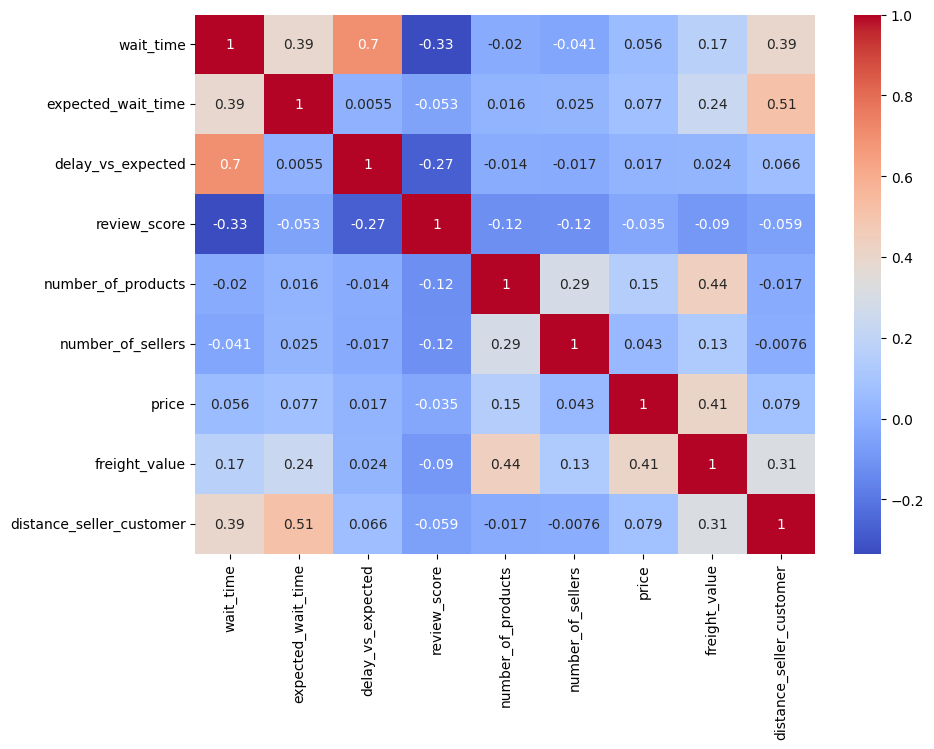

In [9]:
plt.figure(figsize=(10,7))
corr_matrix = orders.select_dtypes(include=np.number
                                  ).drop(columns=['dim_is_one_star'
                                                    ,'dim_is_five_star']).corr()
sns.heatmap(corr_matrix, annot=True,cmap='coolwarm')
plt.show()

💡 The highest correlation coefficients with respect to the `review_score` are `wait_time` (-0.33) and `delay_vs_expected` (-0.27). \
💡 it is likely that overall delivery duration has a high impact on review scores. 

## 2 - Univariate Linear Regression

❓ Does `wait_time` and `delay_vs_expected` really have an impact on review scores? \
❓ Which one has a higher impact on review scores?


### 2.1 Running a univariate linear regression to assess how `wait_time` and `delay_vs_expected` influences review scores. '

***Model 1: `wait_time` vs. `review_score`***

In [11]:
import statsmodels.formula.api as smf

model1 = smf.ols(formula = 'review_score ~ wait_time',data=orders).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:22:22   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.000       4.711       4.736
wait_time     -0.0454      0.000   -109.730      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19552.934   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35454.407
Skew:                          -1.300   Prob(JB):                         0.00
Kurtosis:                       4.453   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

🔎 Interpretation:

Intercept (4.7236): When wait time is 0, the expected review score would be approximately 4.72.

Wait Time Coefficient (-0.0454): For each additional unit increase in wait time, the review score decreases by about 0.0454. The negative sign suggests that longer wait times are associated with lower review scores.

P-Value (0.000): The p-value indicates strong statistical significance, meaning there's a very low chance (less than 0.1%) that the observed relationship is due to random variation. 

R-Squared (0.112): This value suggests that 11.2% of the variation in review scores can be explained by the wait time. While the model shows a significant relationship, there might be other factors influencing review scores that are not accounted for in this regression.

***Model 2: `delay_vs_expected` vs. `review_score`***

In [12]:
model2 = smf.ols(formula = 'review_score ~ delay_vs_expected',data=orders).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:22:48   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.004   1041.192      0.000       4.204       4.220
delay_vs_expected    -0.0752      0.001    -87.644      0.000      -0.077      -0.073
==============================================================================
Omnibus:                    20662.535   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49770.507
Skew:                          -1.203   Prob(JB):                         0.00
Kurtosis:                       5.582   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

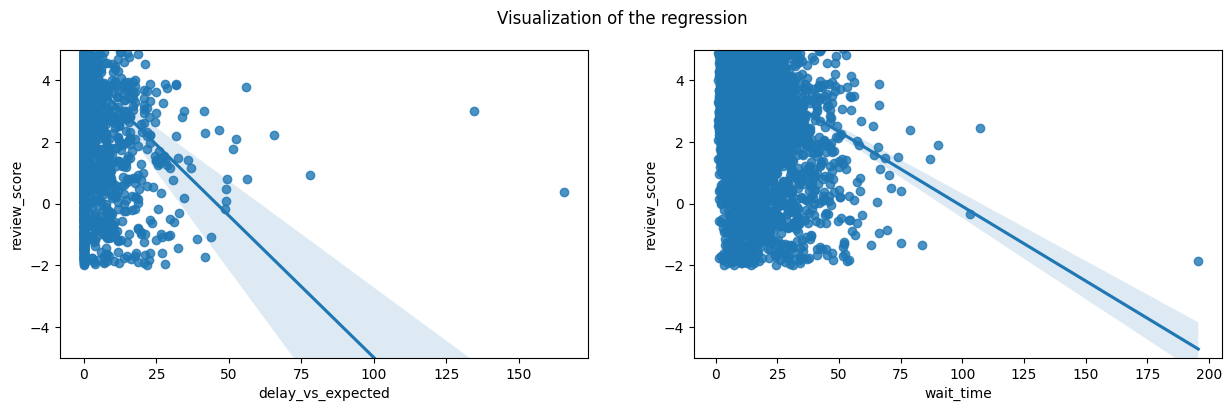

In [27]:
orders_sample = orders.sample(n=10000,random_state=1)
fig,axs = plt.subplots(1,2,figsize=(15,4))

#sns.scatterplot(x='delay_vs_expected',y='review_score',data=orders_sample,ax=axs[0])
sns.regplot(x='delay_vs_expected',y='review_score',data=orders_sample,ax=axs[0],y_jitter=3)
axs[0].set_ylim(-5,5)


#sns.scatterplot(x='wait_time',y='review_score',data=orders_sample,ax=axs[1])
sns.regplot(x='wait_time',y='review_score',data=orders_sample,ax=axs[1],y_jitter=3)
axs[1].set_ylim(-5,5)
plt.suptitle("Visualization of the regression")
plt.show()

🔥 Overall, while both variables show a significant impact, `wait_time` appears to be a more effective predictor than `delay_vs_expected` with a higher R-squared score. However, the stronger coefficient of delay_vs_expected indicates it may have a more direct and immediate effect on reviews.

## 2 - Multivariate Linear Regression 

❓ What is the impact on review_score of adding one day of delay_vs_expected to the order, holding wait_time constant? \
❓ Which of the two features is the most explicative for the low review_score?
❓ What other features could be driving review scores? 


***Model 3***

In [13]:
model3 = smf.ols(formula = 'review_score ~ wait_time + delay_vs_expected',data=orders).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:22:54   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.008    601.568      0.000       4.635       4.665
wait_time            -0.0383      0.001    -65.969      0.000      -0.039      -0.037
delay_vs_expected    -0.0205      0.001    -17.417      0.000      -0.023      -0.018
==============================================================================
Omnibus:                    19995.754   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40513.333
Skew:                          -1.249   Prob(JB):                         0.00
Kurtosis:                       4.976   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

🔎 Interpretation:
- Holding `wait_time` constant, each additional day of `delay_vs_expected` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

🔥 Contrary to what was found with the simple bivariate correlation analysis, `delay_vs_expected` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared is quite low: no more than 12% of the variations of review_score is explained by the combined variations of `wait_time` and `delay_vs_expected`. 

✅ Let's try to add more features to our regression to improve the explainability of the linear regression.

👉 Create a new OLS `model4` with more features from the `orders` dataset.

***Model 4:***


In [15]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

***Normalizing the numerical features***

In [16]:
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
orders_standardized.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115


In [17]:
m4_formula = "review_score ~ " + ' + '.join(features)
model4 = smf.ols(formula = m4_formula,
                 data=orders_standardized).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:23:07   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.1555      0.004   1082.730      0.000       4.148       4.163
wait_time                   -0.4397      0.006    -70.719      0.000      -0.452      -0.428
delay_vs_expected           -0.0515      0.006     -9.023      0.000      -0.063      -0.040
number_of_products          -0.1297      0.004    -28.861      0.000      -0.139      -0.121
number_of_sellers           -0.1314      0.004    -32.747      0.000      -0.139      -0.124
price                       -0.0029      0.004     -0.696      0.486      -0.011       0.005
freight_value                0.0043      0.005      0.868      0.385      -0.005       0.014
distance_seller_customer     0.0967      0.005     20.984      0.000       0.088       0.106
==============================================================================
Omnibus:                    18749.799   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37820.902
Skew:                          -1.175   Prob(JB):                         0.00
Kurtosis:                       4.986   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
❓ What are the most important features? \
❓ How has the overall regression performance changed? \
❓ Is this regression statistically significant? 

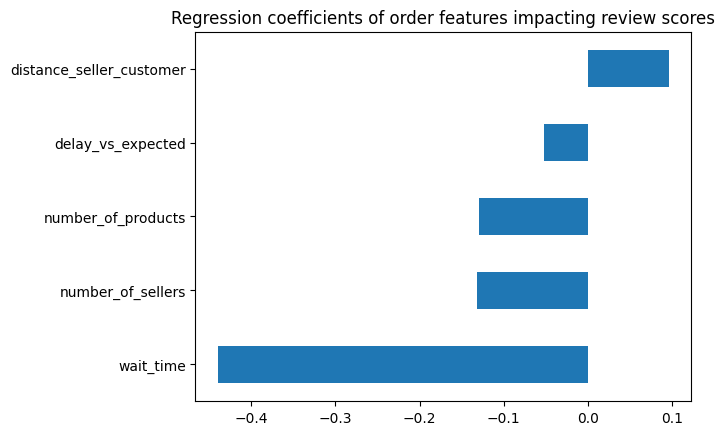

In [28]:
model4.params[1:].drop(['price','freight_value']).sort_values().plot(kind='barh')
plt.title('Regression coefficients of order features impacting review scores')
plt.show()


🔎 Interpretation:
- `price` and `freight_value` are not statistically significant
- `wait_time`, `number_of_sellers`, `number_of_products`, and `delay_vs_expected` seems to have a negative impact on review scores

❌ However, the model has 2 large flaws: 

1. We don't have enough features to explain a significant proportion of the review_scores (low R-squared)
2. We are trying to fit a linear regression function to a discrete classification problem


## 3 - Logistic Regression

❓ What is the Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`? 

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

In [34]:
selected_features = ['wait_time','expected_wait_time','delay_vs_expected','price','number_of_products','number_of_sellers','freight_value','distance_seller_customer']

🕵🏻 Checking `multi-colinearity` of the selected features, using the `VIF index`.

It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
    

In [33]:
standardized_orders = orders.copy()

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_orders[selected_features] = scaler.fit_transform(standardized_orders[selected_features])
standardized_orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431195,-0.934811,-0.161782,delivered,0,0,4,-0.264596,-0.112545,-0.513805,-0.652042,-0.979480
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,-0.524874,-0.161782,delivered,0,0,4,-0.264596,-0.112545,-0.086641,0.000467,0.429745
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329909,0.330880,-0.161782,delivered,1,0,5,-0.264596,-0.112545,0.111749,-0.164054,-0.145496
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,0.279447,-0.161782,delivered,1,0,5,-0.264596,-0.112545,-0.441528,0.206816,2.054632
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019540,-1.326304,-0.161782,delivered,1,0,5,-0.264596,-0.112545,-0.562391,-0.652042,-0.959120


👉 Run VIF Analysis to analyze the potential multicolinearities:\
The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction.

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_df = standardized_orders[selected_features]
vif(vif_df.values,0)

3.0605745087767335

In [37]:
df = pd.DataFrame()
df["features"] = vif_df.columns
df["vif_index"] = [vif(vif_df.values, i) for i in range(vif_df.shape[1])]
round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
0,wait_time,3.06
2,delay_vs_expected,2.45
6,freight_value,1.68
1,expected_wait_time,1.60
7,distance_seller_customer,1.60
4,number_of_products,1.37
3,price,1.21
5,number_of_sellers,1.10


We are good to proceed because the VIF does not exceed 4 for any of our features

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

**logit_one model**

In [38]:
selected_features = ['wait_time','expected_wait_time','delay_vs_expected','price','number_of_products','number_of_sellers','freight_value','distance_seller_customer']
formula = f"dim_is_one_star ~ {' + '.join(selected_features)}"
logit_one = smf.logit(formula = formula, data = standardized_orders).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.272741
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                  0.1474
Time:                        12:31:16   Log-Likelihood:                -26148.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4842      0.013   -189.094      0.000      -2.510      -2.458
wait_time                    0.8353      0.020     42.415      0.000       0.797       0.874
expected_wait_time          -0.2048      0.017    -12.355      0.000      -0.237      -0.172
delay_vs_expected            0.1395      0.020      6.845      0.000       0.100       0.179
price                        0.0515      0.011      4.571      0.000       0.029       0.074
number_of_products           0.2500      0.011     23.714      0.000       0.229       0.271
number_of_sellers            0.1863      0.008     23.517      0.000       0.171       0.202
freight_value               -0.0128      0.012     -1.027      0.304      -0.037       0.012
distance_seller_customer    -0.1300      0.014     -9.103      0.000      -0.158      -0.102
============================================================================================
"""

In [ ]:
model4.params[1:].drop(['price','freight_value']).sort_values().plot(kind='barh')
plt.title('Regression coefficients of order features impacting review scores')
plt.show()

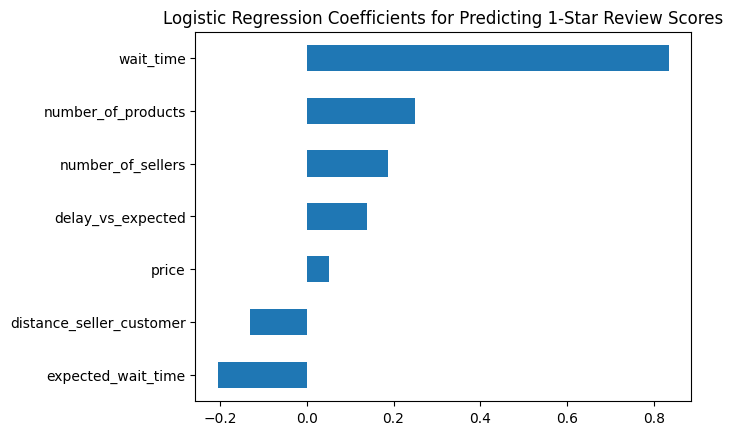

In [40]:
logit_one.params[1:].drop(['freight_value']).sort_values().plot(kind='barh')
plt.title('Logistic Regression Coefficients for Predicting 1-Star Review Scores')
plt.show()

**logit_five model**

In [42]:
formula = f"dim_is_five_star ~ {' + '.join(selected_features)}"
logit_five = smf.logit(formula = formula, data = standardized_orders).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.636466
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                 0.05859
Time:                        12:32:27   Log-Likelihood:                -61019.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3416      0.007     47.749      0.000       0.328       0.356
wait_time                   -0.5642      0.013    -44.283      0.000      -0.589      -0.539
expected_wait_time           0.0736      0.009      8.323      0.000       0.056       0.091
delay_vs_expected           -0.3753      0.024    -15.529      0.000      -0.423      -0.328
price                        0.0204      0.008      2.676      0.007       0.005       0.035
number_of_products          -0.1359      0.008    -16.240      0.000      -0.152      -0.120
number_of_sellers           -0.1455      0.008    -18.546      0.000      -0.161      -0.130
freight_value                0.0009      0.009      0.101      0.919      -0.017       0.019
distance_seller_customer     0.0649      0.009      7.450      0.000       0.048       0.082
============================================================================================
"""

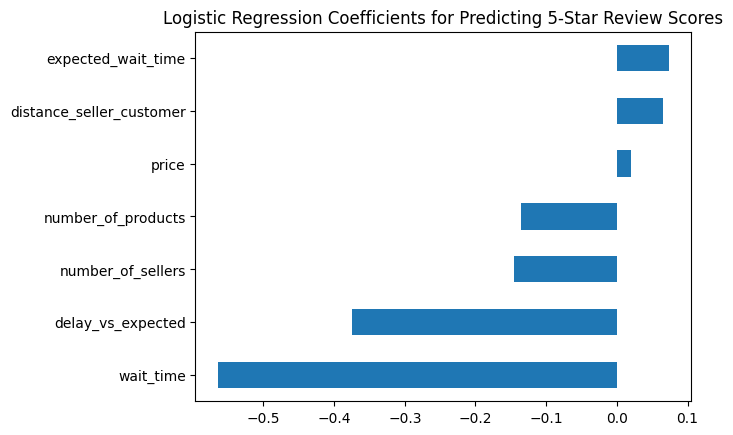

In [45]:
logit_five.params[1:].drop(['freight_value']).sort_values().plot(kind='barh')
plt.title('Logistic Regression Coefficients for Predicting 5-Star Review Scores')
plt.show()

💡 Interpretation of the results of the 2 logistic regressions:
- delay_vs_expected influences five_star ratings even more than one_star ratings
- wait_time influences one_star ratings even more more than five_star